In [1]:
import pandas as pd
import numpy as np
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from datetime import timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_sample_weight

#### Função que permite ver os tipos de cada coluna, quantos valores únicos existem por coluna, valores nulos e a quantidade de linhas

In [2]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['DTypes'])
    summary_df['Nunique'] = df.nunique()
    summary_df['MissingValues'] = df.isnull().sum()
    summary_df['Count'] = df.count()
    
    print(summary_df)

In [3]:
def heatmap(df,title):
    
    fig, axes = plt.subplots(figsize=(15, 15))
    corr = df.corr()            # Calculate correlation of param

    mask = np.zeros_like(corr)   # Create a array of zeros with the same shape as the df provided
    # print(mask)

    mask[np.triu_indices_from(mask)] = True    # set the index of the upper triangle of the array to True (1)
    # print(mask)

    with sns.axes_style("white"):
        sns.heatmap(corr, linewidths=1, 
                    annot=True, 
                    mask=mask, 
                    vmax=.3, 
                    square=True,
                   fmt=".2f",
                   cbar=True)  # mask: data will not be
        plt.suptitle(title, size="30")
        
        


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [5]:
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    #weighted for imbalanced data
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    #y_test = pd.get_dummies(y_test)
    #y_pred = pd.get_dummies(y_pred)
    #print (y_pred.head())
    print (y_pred)
    n_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve 
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

#### Leitura do arquivo BrFlights2.csv:
1. Retirando colunas consideradas desnecessárias
2. Convertendo colunas para Y-%m-%d %H:%M:%S
3. Garantindo conversão para datetime
4. Guardando na Coluna AtrasoVoo o tempo de atraso de Voo
5. Preenchendo os NAs de AtrasoVoo com 100000, supondo que é um valor muito maior que o de um atraso normal

In [6]:



%matplotlib inline
flights = pd.read_csv("dados/BrFlights2.csv", encoding="utf8")
#Removendo colunas desnecessárias
flights.drop(["Codigo.Tipo.Linha","Companhia.Aerea","Pais.Origem","Pais.Destino", "Estado.Origem", "Estado.Destino", "Cidade.Origem", "Cidade.Destino"], axis=1, inplace=True)

#Convertendo para o formato %Y-%m-%d %H:%M:%S
# com o coerce o código executa e caso não consiga ler um valor, ele coloca NaT
flights['Partida.Prevista'] = pd.to_datetime(flights['Partida.Prevista'] , errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
flights['Partida.Real'] = pd.to_datetime(flights['Partida.Real'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
flights['Chegada.Prevista'] = pd.to_datetime(flights['Chegada.Prevista'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
flights['Chegada.Real'] = pd.to_datetime(flights['Chegada.Real'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

flights['Chegada.Prevista'] = pd.to_datetime(flights['Chegada.Prevista'], errors='coerce')
flights['Partida.Prevista'] = pd.to_datetime(flights['Partida.Prevista'] , errors='coerce')
flights['Chegada.Real'] = pd.to_datetime(flights['Chegada.Real'], errors='coerce')
flights['Partida.Real'] = pd.to_datetime(flights['Partida.Real'] , errors='coerce')

flights["AtrasoVoo"] =flights['Chegada.Real'] - flights['Chegada.Prevista'] 
#Contando o tempo em minutos de voos que deram certo
flights['AtrasoVoo'] = flights['AtrasoVoo'].dt.total_seconds().div(60).fillna(100000).astype(int)

flights.AtrasoVoo[flights["AtrasoVoo"] < 0] = 0 # Minutos negativos foram considerados 0, pois a previsao de voos geralmente sao maiores para evitar problemas no tráfego aereo

display (flights.head())

print(list(flights['Situacao.Voo'].unique()),"\n")
#print(list(flights['Aeroporto.Origem'].unique()))
#print(list(flights['Codigo.Justificativa'].unique()))

# station,valid,lon,lat,tmpf, dwpf, relh, drct, sknt, p01i, alti, mslp, vsby, gust, skyc1, skyc2, skyc3, skyc4, skyl1, skyl2, skyl3, skyl4, wxcodes, ice_accretion_1hr, ice_accretion_3hr, ice_accretion_6hr, metar

flights['Codigo.Justificativa'] = flights['Codigo.Justificativa'].fillna("OK").astype(str)

/home/pgdock/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo
0,AAL - 203,2016-01-30 08:58:00,2016-01-30 08:58:00,2016-01-30 10:35:00,2016-01-30 10:35:00,Realizado,NaN,Afonso Pena,Salgado Filho,-51.175381,-29.993473,-49.172481,-25.532713,0
1,AAL - 203,2016-01-13 12:13:00,2016-01-13 12:13:00,2016-01-13 21:30:00,2016-01-13 21:30:00,Realizado,NaN,Salgado Filho,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
2,AAL - 203,2016-01-29 12:13:00,2016-01-29 12:13:00,2016-01-29 21:30:00,2016-01-29 21:30:00,Realizado,NaN,Salgado Filho,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
3,AAL - 203,2016-01-19 12:13:00,2016-01-18 12:03:00,2016-01-19 21:30:00,2016-01-18 20:41:00,Realizado,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO,Salgado Filho,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
4,AAL - 203,2016-01-30 12:13:00,2016-01-30 12:13:00,2016-01-30 21:30:00,2016-01-30 21:30:00,Realizado,NaN,Salgado Filho,Miami,-80.287046,25.795865,-51.175381,-29.993473,0


['Realizado', 'Cancelado'] 



In [7]:
summary(flights)

                              DTypes  Nunique  MissingValues    Count
Voos                          object     6257              0  2542519
Partida.Prevista      datetime64[ns]   738010              0  2542519
Partida.Real          datetime64[ns]   857132         289196  2253323
Chegada.Prevista      datetime64[ns]   779401              0  2542519
Chegada.Real          datetime64[ns]   881986         289196  2253323
Situacao.Voo                  object        2              0  2542519
Codigo.Justificativa          object       42              0  2542519
Aeroporto.Origem              object      189              0  2542519
Aeroporto.Destino             object      189              0  2542519
LongDest                     float64      189              0  2542519
LatDest                      float64      189              0  2542519
LongOrig                     float64      189              0  2542519
LatOrig                      float64      189              0  2542519
AtrasoVoo           

In [8]:
print(flights[flights['Situacao.Voo'] == "Cancelado" ].shape)
aux = flights[flights['Situacao.Voo'] == "Cancelado" ]
aux.to_csv("cancelados.csv", index=False)

(289196, 14)


#### Lendo códigos e aeroportos do arquivo 'codigos.csv' para substituir o nome contido em Aeroporto.Origem e Aeroporto.Destino pelo Codigo dele

In [9]:
codigos = pd.read_csv("dados/codigos.csv")
aeroportos = codigos.Codigo #Códigos como SBCT, SBGR... 

codigos = dict(zip(codigos.Nome, codigos.Codigo))
print (codigos)

flights.replace({"Aeroporto.Origem" : codigos}, inplace=True)
flights.replace({"Aeroporto.Destino" : codigos}, inplace=True)
flights.head(10)

{'Afonso Pena': 'SBCT', 'Aeroporto Internacional Do Rio De Janeiro/Galeao': 'SBGL', 'Guarulhos - Governador Andre Franco Montoro': 'SBGR', 'Eduardo Gomes': 'SBMN', 'Salgado Filho': 'SBPA', 'Congonhas': 'SBSP', 'Tancredo Neves': 'SBCF'}


,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo
0,AAL - 203,2016-01-30 08:58:00,2016-01-30 08:58:00,2016-01-30 10:35:00,2016-01-30 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0
1,AAL - 203,2016-01-13 12:13:00,2016-01-13 12:13:00,2016-01-13 21:30:00,2016-01-13 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
2,AAL - 203,2016-01-29 12:13:00,2016-01-29 12:13:00,2016-01-29 21:30:00,2016-01-29 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
3,AAL - 203,2016-01-19 12:13:00,2016-01-18 12:03:00,2016-01-19 21:30:00,2016-01-18 20:41:00,Realizado,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
4,AAL - 203,2016-01-30 12:13:00,2016-01-30 12:13:00,2016-01-30 21:30:00,2016-01-30 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
5,AAL - 203,2016-01-03 23:05:00,2016-01-03 23:05:00,2016-01-04 07:50:00,2016-01-04 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0
6,AAL - 203,2016-01-05 23:05:00,2016-01-05 23:35:00,2016-01-06 07:50:00,2016-01-06 08:35:00,Realizado,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,45
7,AAL - 203,2016-01-18 12:13:00,2016-01-18 13:09:00,2016-01-18 21:30:00,2016-01-18 22:24:00,Realizado,CONEXAO DE AERONAVE,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,54
8,AAL - 203,2016-01-22 23:05:00,2016-01-22 23:05:00,2016-01-23 07:50:00,2016-01-23 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0
9,AAL - 203,2016-01-15 23:05:00,2016-01-15 23:55:00,2016-01-16 07:50:00,2016-01-16 08:28:00,Realizado,ATRASOS NAO ESPECIFICOS - OUTROS,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,38


#### Retirando voos que nao contem os aeroportos escolhidos (que estao no arquivo codigos.csv) e printando todos os Codigos.Justificativa existentes

In [10]:

flights = flights[flights["Aeroporto.Origem"].isin(aeroportos) | (flights["Aeroporto.Destino"].isin(aeroportos))]

print(flights.shape)
print(list(flights['Codigo.Justificativa'].unique()))

(1696967, 14)
['OK', 'LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO', 'CONEXAO DE AERONAVE', 'ATRASOS NAO ESPECIFICOS - OUTROS', 'DEFEITOS DA AERONAVE', 'AEROPORTO ORIGEM ABAIXO DOS LIMITES', 'OPERACAO DE VOO COM MAIS DE 04 HORAS DE ATRASO PANE AERONAVE', 'CANCELAMENTO POR MOTIVOS TECNICOS - OPERACIONAIS', 'SEGURANCA/PAX/CARGA/ALARME', 'PLANO DE VOO -  APROVACAO', 'FALHA EQUIPO AUTOMOTIVO E DE ATENDIMENTO DE PAX', 'FACILIDADES DO AEROPORTO - RESTRICOES DE APOIO', 'AEROPORTO COM RESTRICOES OPERACIONAIS', 'MIGRACAO/ALFANDEGA/SAUDE', 'AUTORIZADA', 'TROCA DE AERONAVE', 'AUTORIZADO', 'AEROPORTO DE ORIGEM INTERDITADO', 'AVARIA DURANTE OPERACOES EM VOO', 'AVARIA DURANTE OPERACOES EM SOLO', 'CANCELAMENTO - AEROPORTO DESTINO ABAIXO LIMITES', 'ANTECIPACAO DE HORARIO AUTORIZADA', 'AEROPORTO DESTINO ABAIXO DOS LIMITES', 'CONEXAO AERONAVE/VOLTA - VOO DE IDA NAO PENALIZADO CONDICOES METEOROLOGICAS', 'CANCELAMENTO - AEROPORTO ORIGEM ABAIXO LIMITES', 'CONEXAO AERONAVE/VOLTA - VOO DE IDA NAO PENALIZADO AER

#### Retirar Codigos.Justificativas nao necessarios (manter apenas os que envolvem problemas meteorológicos)

In [11]:
relevantes = ["OK","ATRASO DEVIDO RETORNO - CONDICOES METEOROLOGICAS","AEROPORTO ORIGEM ABAIXO DOS LIMITES","AEROPORTO DESTINO ABAIXO DOS LIMITES", "CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE IDA CANCELADO - CONDICOES METEOROLOGICAS" ]
flights = flights[flights["Codigo.Justificativa"].isin(relevantes) | flights["Codigo.Justificativa"].isnull()  ]
#flights.reset_index(drop=True,inplace=True)

#flights = flights[flights["Situacao.Voo"] != "Cancelado"]
print(flights.shape)
print(list(flights['Codigo.Justificativa'].unique())) #Confirmando que só ficaram essas colunas
#print(flights.groupby("Codigo.Justificativa"))



flights.head()



(1095187, 14)
['OK', 'AEROPORTO ORIGEM ABAIXO DOS LIMITES', 'AEROPORTO DESTINO ABAIXO DOS LIMITES', 'ATRASO DEVIDO RETORNO - CONDICOES METEOROLOGICAS', 'CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE IDA CANCELADO - CONDICOES METEOROLOGICAS']


,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo
0,AAL - 203,2016-01-30 08:58:00,2016-01-30 08:58:00,2016-01-30 10:35:00,2016-01-30 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0
1,AAL - 203,2016-01-13 12:13:00,2016-01-13 12:13:00,2016-01-13 21:30:00,2016-01-13 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
2,AAL - 203,2016-01-29 12:13:00,2016-01-29 12:13:00,2016-01-29 21:30:00,2016-01-29 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
4,AAL - 203,2016-01-30 12:13:00,2016-01-30 12:13:00,2016-01-30 21:30:00,2016-01-30 21:30:00,Realizado,OK,SBPA,Miami,-80.287046,25.795865,-51.175381,-29.993473,0
5,AAL - 203,2016-01-03 23:05:00,2016-01-03 23:05:00,2016-01-04 07:50:00,2016-01-04 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0


#### Caso o Codigo Justificativa contenha ORIGEM ou IDA indica que o problema ocorre no aeroporto de origem, por isso:
* Salvar o Aeroporto.Origem em Aeroporto.Importante e Partida.Prevista para Hora.Prevista e Partida.Real para Hora.Real 

#### Caso contrário:
* Salvar o Aeroporto.Destino em Aeroporto.Importante e Chegada.Prevista para Hora.Prevista e Chegada.Real para Hora.Real

OBS: Existem 4 tipos que contém uma das substring a seguir exclusivamente : "ORIGEM","IDA,"DESTINO","RETORNO"
OBS2: no caso do Codigo.Justificativa NaN eu escolhi o dados do Aeroporto Destino como referencia 
#### Depois mantendo apenas aeroportos escolhidos no arquivo "codigos.csv"

In [12]:
flights["Aeroporto.Importante"] =np.where(flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False) | flights["Codigo.Justificativa"].str.contains("IDA",na=False), flights["Aeroporto.Origem"] , flights["Aeroporto.Destino"] )
flights["Hora.Prevista"] = np.where(flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False) | flights["Codigo.Justificativa"].str.contains("IDA",na=False), flights["Partida.Prevista"] , flights["Chegada.Prevista"] )
flights["Hora.Real"] =np.where(flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False) | flights["Codigo.Justificativa"].str.contains("IDA",na=False), flights["Partida.Real"] , flights["Chegada.Real"] )

flights = flights[flights["Aeroporto.Importante"].isin(aeroportos)]

n_delay = (flights[flights["Codigo.Justificativa"].str.contains("DESTINO",na=False) | flights["Codigo.Justificativa"].str.contains("RETORNO",na=False)].shape[0] + flights[flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False)].shape[0])
print (n_delay)
n_cancel = flights[flights["Codigo.Justificativa"].str.contains("IDA",na=False)].shape[0]
print (n_cancel)


print ((flights[flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False) | flights["Codigo.Justificativa"].str.contains("IDA",na=False)].shape[0] + flights[flights["Codigo.Justificativa"].str.contains("DESTINO",na=False)].shape[0] + flights[flights["Codigo.Justificativa"].str.contains("RETORNO",na=False)].shape[0])/flights.shape[0])
flights.head(7)

9846
568
0.015843747242482054


,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo,Aeroporto.Importante,Hora.Prevista,Hora.Real
0,AAL - 203,2016-01-30 08:58:00,2016-01-30 08:58:00,2016-01-30 10:35:00,2016-01-30 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0,SBPA,2016-01-30 10:35:00,2016-01-30 10:35:00
5,AAL - 203,2016-01-03 23:05:00,2016-01-03 23:05:00,2016-01-04 07:50:00,2016-01-04 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0,SBCT,2016-01-04 07:50:00,2016-01-04 07:50:00
8,AAL - 203,2016-01-22 23:05:00,2016-01-22 23:05:00,2016-01-23 07:50:00,2016-01-23 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0,SBCT,2016-01-23 07:50:00,2016-01-23 07:50:00
12,AAL - 203,2016-01-05 08:58:00,2016-01-05 08:58:00,2016-01-05 10:35:00,2016-01-05 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0,SBPA,2016-01-05 10:35:00,2016-01-05 10:35:00
14,AAL - 203,2016-01-31 08:58:00,2016-01-31 08:58:00,2016-01-31 10:35:00,2016-01-31 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0,SBPA,2016-01-31 10:35:00,2016-01-31 10:35:00
16,AAL - 203,2016-01-12 08:58:00,2016-01-12 08:58:00,2016-01-12 10:35:00,2016-01-12 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,0,SBPA,2016-01-12 10:35:00,2016-01-12 10:35:00
18,AAL - 203,2016-01-21 23:05:00,2016-01-21 23:05:00,2016-01-22 07:50:00,2016-01-22 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,-25.532713,-80.287046,25.795865,0,SBCT,2016-01-22 07:50:00,2016-01-22 07:50:00


#### Teste para checar se Aeroporto.Importante é igual ao Aeroporto.Origem se o código contém "Origem"

In [13]:
flights[flights["Codigo.Justificativa"].str.contains("ORIGEM",na=False)].head(5) 

,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo,Aeroporto.Importante,Hora.Prevista,Hora.Real
685,AAL - 974,2016-01-15 23:00:00,2016-01-15 23:49:00,2016-01-16 09:11:00,2016-01-16 09:30:00,Realizado,AEROPORTO ORIGEM ABAIXO DOS LIMITES,SBGL,New York,-73.778139,40.641311,-43.249423,-22.813410,19,SBGL,2016-01-15 23:00:00,2016-01-15 23:49:00
2942,AZU - 2411,2016-01-15 07:50:00,2016-01-15 08:19:00,2016-01-15 09:15:00,2016-01-15 09:50:00,Realizado,AEROPORTO ORIGEM ABAIXO DOS LIMITES,SBCF,SBGR,-46.478126,-23.434553,-43.965396,-19.634099,35,SBCF,2016-01-15 07:50:00,2016-01-15 08:19:00
3004,AZU - 2413,2016-01-13 13:05:00,2016-01-13 15:31:00,2016-01-13 14:30:00,2016-01-13 16:44:00,Realizado,AEROPORTO ORIGEM ABAIXO DOS LIMITES,SBCF,SBGR,-46.478126,-23.434553,-43.965396,-19.634099,134,SBCF,2016-01-13 13:05:00,2016-01-13 15:31:00
3476,AZU - 2446,2016-01-15 13:33:00,2016-01-15 15:16:00,2016-01-15 16:05:00,2016-01-15 17:47:00,Realizado,AEROPORTO ORIGEM ABAIXO DOS LIMITES,SBCF,Prefeito Renato Moreira,-47.456070,-5.531695,-43.965396,-19.634099,102,SBCF,2016-01-15 13:33:00,2016-01-15 15:16:00
3480,AZU - 2446,2016-01-13 13:33:00,2016-01-13 15:31:00,2016-01-13 16:05:00,2016-01-13 18:00:00,Realizado,AEROPORTO ORIGEM ABAIXO DOS LIMITES,SBCF,Prefeito Renato Moreira,-47.456070,-5.531695,-43.965396,-19.634099,115,SBCF,2016-01-13 13:33:00,2016-01-13 15:31:00


#### Convertendo colunas para datetime:
1. Caso contenha algum valor inválido será considerado NaT (devido ao errors='coerce')
2. Os valores em seguida são arredondados para a hora mais próxima com os minutos = "00"

In [14]:
flights['Hora.Real'] = pd.to_datetime(flights['Hora.Real'], errors='coerce')
flights['Hora.Prevista'] = pd.to_datetime(flights['Hora.Prevista'], errors='coerce')

flights["Hora.Real"] = pd.Series(flights["Hora.Real"]).dt.round("H")
flights["Hora.Prevista"] = pd.Series(flights["Hora.Prevista"]).dt.round("H")


#flights['Hora.Prevista'] = pd.to_datetime(flights['Hora.Prevista']) - timedelta(hours=2) #Test
flights.tail()

,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo,Aeroporto.Importante,Hora.Prevista,Hora.Real
2542509,UAL - 129,2015-12-15 01:25:00,2015-12-15 01:25:00,2015-12-15 11:19:00,2015-12-15 11:19:00,Realizado,OK,Houston,SBGL,-43.249423,-22.81341,-95.336783,29.99022,0,SBGL,2015-12-15 11:00:00,2015-12-15 11:00:00
2542512,UAL - 129,2015-12-30 01:25:00,2015-12-30 01:25:00,2015-12-30 11:19:00,2015-12-30 11:19:00,Realizado,OK,Houston,SBGL,-43.249423,-22.81341,-95.336783,29.99022,0,SBGL,2015-12-30 11:00:00,2015-12-30 11:00:00
2542515,UAL - 129,2015-12-01 01:25:00,2015-12-01 01:25:00,2015-12-01 11:19:00,2015-12-01 11:19:00,Realizado,OK,Houston,SBGL,-43.249423,-22.81341,-95.336783,29.99022,0,SBGL,2015-12-01 11:00:00,2015-12-01 11:00:00
2542516,UAL - 129,2015-12-27 01:25:00,2015-12-27 01:25:00,2015-12-27 11:19:00,2015-12-27 11:19:00,Realizado,OK,Houston,SBGL,-43.249423,-22.81341,-95.336783,29.99022,0,SBGL,2015-12-27 11:00:00,2015-12-27 11:00:00
2542518,UAL - 129,2015-12-09 01:25:00,2015-12-09 01:25:00,2015-12-09 11:19:00,2015-12-09 11:19:00,Realizado,OK,Houston,SBGL,-43.249423,-22.81341,-95.336783,29.99022,0,SBGL,2015-12-09 11:00:00,2015-12-09 11:00:00


#### Leitura dos arquivos do METAR dos aeroportos
1. Leitura de cada aeroporto individualmente
2. Concatenação dos arquivos
3. Renomeando colunas (pois havia um espaço em branco no inicio de cada coluna)
4. Retirando colunas desnecessárias


In [15]:
for i in aeroportos:
    namefile = "dados/"+i+"_201601010000_201712010000.csv"
    try:
        data
    except NameError:
        data = pd.read_csv(namefile,skiprows=5, encoding="utf8")
    else:
        aux = pd.read_csv(namefile,skiprows=5, encoding="utf8")
        data = pd.concat([data, aux])

data.columns =['Aeroporto.Importante', 'Hora.Prevista', 'lon', 'lat', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr', 'metar']
data.drop(["wxcodes","ice_accretion_1hr", "ice_accretion_3hr","ice_accretion_6hr", "metar"], axis=1, inplace=True)
data.head()


,Aeroporto.Importante,Hora.Prevista,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
0,SBCT,2016-01-01 00:00,-49.1758,-25.5285,73.40,66.20,78.19,240.00,7.00,0.0,...,6.21,M,FEW,M,M,M,4000.00,M,M,M
1,SBCT,2016-01-01 01:00,-49.1758,-25.5285,71.60,62.60,73.27,280.00,2.00,0.0,...,6.21,M,M,M,M,M,M,M,M,M
2,SBCT,2016-01-01 02:00,-49.1758,-25.5285,69.80,64.40,82.98,50.00,3.00,0.0,...,6.21,M,M,M,M,M,M,M,M,M
3,SBCT,2016-01-01 03:00,-49.1758,-25.5285,68.00,64.40,88.26,70.00,5.00,0.0,...,6.21,M,M,M,M,M,M,M,M,M
4,SBCT,2016-01-01 04:00,-49.1758,-25.5285,68.00,64.40,88.26,100.00,4.00,0.0,...,6.21,M,M,M,M,M,M,M,M,M


In [16]:
summary(data)

                       DTypes  Nunique  MissingValues   Count
Aeroporto.Importante   object        7              0  125945
Hora.Prevista          object    27474              0  125945
lon                   float64        7              0  125945
lat                   float64        7              0  125945
tmpf                   object       68              0  125945
dwpf                   object       66              0  125945
relh                   object     1007              0  125945
drct                   object       76              0  125945
sknt                   object       73              0  125945
p01i                  float64        1              0  125945
alti                   object       76              0  125945
mslp                   object        1              0  125945
vsby                   object       93              0  125945
gust                   object       39              0  125945
skyc1                  object        9              0  125945
skyc2   

In [17]:
print(list(data['skyc1'].unique()))

['FEW', 'M', 'BKN', 'OVC', 'SCT', 'VV ', 'NSC', 'NCD', '///']


#### Alterando valores de string das variáveis, para valores numéricos
Em level : Quanto maior o M melhor


In [18]:
coverage = {"M": 0, "FEW" : 2, "SCT": 4 ,"BKN": 6, "OVC": 8, "VV ": 8, "///": 8, "NSC": 0, "NCD": 2  }
level = {"M": 10000.00}
others = {"M":0}
data.replace({"gust":{"M":0},"skyc1" : coverage  , "skyc2" : coverage, "skyc3" : coverage, "skyc4" : coverage, "skyl1" : level , "skyl2" : level, "skyl3" : level, "skyl4" : level, "tmpf": others, "dwpf": others, "relh": others, "drct": others, "sknt": others,"alti": others, "vsby": others}, inplace=True)

data.head()


,Aeroporto.Importante,Hora.Prevista,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
0,SBCT,2016-01-01 00:00,-49.1758,-25.5285,73.40,66.20,78.19,240.00,7.00,0.0,...,6.21,0,2,0,0,0,4000.00,10000,10000,10000
1,SBCT,2016-01-01 01:00,-49.1758,-25.5285,71.60,62.60,73.27,280.00,2.00,0.0,...,6.21,0,0,0,0,0,10000,10000,10000,10000
2,SBCT,2016-01-01 02:00,-49.1758,-25.5285,69.80,64.40,82.98,50.00,3.00,0.0,...,6.21,0,0,0,0,0,10000,10000,10000,10000
3,SBCT,2016-01-01 03:00,-49.1758,-25.5285,68.00,64.40,88.26,70.00,5.00,0.0,...,6.21,0,0,0,0,0,10000,10000,10000,10000
4,SBCT,2016-01-01 04:00,-49.1758,-25.5285,68.00,64.40,88.26,100.00,4.00,0.0,...,6.21,0,0,0,0,0,10000,10000,10000,10000


In [19]:
summary(data)
data.drop(["mslp", "p01i", "lat", "lon"], axis=1, inplace=True)

                       DTypes  Nunique  MissingValues   Count
Aeroporto.Importante   object        7              0  125945
Hora.Prevista          object    27474              0  125945
lon                   float64        7              0  125945
lat                   float64        7              0  125945
tmpf                   object       68              0  125945
dwpf                   object       66              0  125945
relh                   object     1007              0  125945
drct                   object       75              0  125945
sknt                   object       72              0  125945
p01i                  float64        1              0  125945
alti                   object       76              0  125945
mslp                   object        1              0  125945
vsby                   object       92              0  125945
gust                   object       39              0  125945
skyc1                   int64        5              0  125945
skyc2   

#### Checando colunas que contem a letra M, pois todas as colunas tem que ter valores numéricos e testando skc1
OBS: A coluna mslp foi mantida com "Ms", pois será deletada

In [20]:
data[data=="M"].any()
print(list(data['skyc1'].unique()))

[2, 0, 6, 8, 4]


#### Checando se contém o tipo datetime ou equivalente

In [21]:
data["Hora.Prevista"] = pd.to_datetime(data['Hora.Prevista'])
data["Hora.Prevista"].dtypes

dtype('<M8[ns]')

In [22]:
#Showing flights with canceled status
display(flights[flights['Situacao.Voo'] == "Cancelado" ].head(30))

,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,LatDest,LongOrig,LatOrig,AtrasoVoo,Aeroporto.Importante,Hora.Prevista,Hora.Real
12590,AZU - 4041,2016-01-16 07:54:00,NaT,2016-01-16 09:09:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Viracopos,-47.137569,-23.008205,-43.965396,-19.634099,100000,SBCF,2016-01-16 08:00:00,NaT
15440,AZU - 4191,2016-01-16 06:32:00,NaT,2016-01-16 07:48:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Viracopos,-47.137569,-23.008205,-43.965396,-19.634099,100000,SBCF,2016-01-16 07:00:00,NaT
16047,AZU - 4210,2016-01-13 12:06:00,NaT,2016-01-13 13:23:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Porto Seguro,-39.082143,-16.439530,-43.965396,-19.634099,100000,SBCF,2016-01-13 12:00:00,NaT
23189,AZU - 5071,2016-01-13 11:42:00,NaT,2016-01-13 12:43:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Santos Dumont,-43.164876,-22.911144,-43.965396,-19.634099,100000,SBCF,2016-01-13 12:00:00,NaT
31539,GLO - 1122,2016-01-09 07:38:00,NaT,2016-01-09 08:35:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,Regional De Maringa - Silvio Name Junior,-52.016484,-23.476610,-49.172481,-25.532713,100000,SBCT,2016-01-09 08:00:00,NaT
31724,GLO - 1124,2016-01-15 09:32:00,NaT,2016-01-15 11:06:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,SBCF,-43.965396,-19.634099,-49.172481,-25.532713,100000,SBCT,2016-01-15 10:00:00,NaT
31770,GLO - 1125,2016-01-16 09:45:00,NaT,2016-01-16 10:53:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,100000,SBCT,2016-01-16 10:00:00,NaT
31777,GLO - 1125,2016-01-15 07:27:00,NaT,2016-01-15 09:10:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,SBCT,-49.172481,-25.532713,-43.965396,-19.634099,100000,SBCF,2016-01-15 07:00:00,NaT
31780,GLO - 1125,2016-01-15 09:45:00,NaT,2016-01-15 10:53:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,SBPA,-51.175381,-29.993473,-49.172481,-25.532713,100000,SBCT,2016-01-15 10:00:00,NaT
32438,GLO - 1156,2016-01-15 22:10:00,NaT,2016-01-15 23:15:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Eurico De Aguiar Salles,-40.283535,-20.257649,-43.965396,-19.634099,100000,SBCF,2016-01-15 22:00:00,NaT


#### Unindo tabelas
1. Unindo tabelas Voos existentes e dos Metar de cada Aeroporto
2. Os valores da Uniao são a Hora.Prevista (pois é a Hora que ocorreu o problema) e o Aeroporto.Importante (local onde ocorreu o problema) 
3. São mantidas as intersecções dos voos e dos metares existentes

In [23]:
#Juntando tabelas
Data = pd.merge(flights, data, how='inner', on=['Aeroporto.Importante', 'Hora.Prevista'])
display(Data.head(10))
print(Data.shape)

,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,...,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
0,AAL - 203,2016-01-30 08:58:00,2016-01-30 08:58:00,2016-01-30 10:35:00,2016-01-30 10:35:00,Realizado,OK,SBCT,SBPA,-51.175381,...,6.21,0,0,0,0,0,10000,10000,10000,10000
1,GLO - 1125,2016-01-30 09:45:00,2016-01-30 09:45:00,2016-01-30 10:53:00,2016-01-30 10:53:00,Realizado,OK,SBCT,SBPA,-51.175381,...,6.21,0,0,0,0,0,10000,10000,10000,10000
2,TAM - 3289,2016-01-30 09:20:00,2016-01-30 09:20:00,2016-01-30 11:00:00,2016-01-30 11:00:00,Realizado,OK,SBGR,SBPA,-51.175381,...,6.21,0,0,0,0,0,10000,10000,10000,10000
3,TAM - 3411,2016-01-30 08:20:00,2016-01-30 08:20:00,2016-01-30 10:40:00,2016-01-30 10:40:00,Realizado,OK,SBGL,SBPA,-51.175381,...,6.21,0,0,0,0,0,10000,10000,10000,10000
4,AAL - 203,2016-01-03 23:05:00,2016-01-03 23:05:00,2016-01-04 07:50:00,2016-01-04 07:50:00,Realizado,OK,Miami,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000
5,AZU - 5728,2016-01-04 06:41:00,2016-01-04 06:41:00,2016-01-04 07:57:00,2016-01-04 07:57:00,Realizado,OK,Adalberto Mendes Da Silva,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000
6,TAM - 3001,2016-01-04 06:40:00,2016-01-04 06:40:00,2016-01-04 07:36:00,2016-01-04 07:36:00,Realizado,OK,SBSP,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000
7,TAM - 3090,2016-01-04 07:02:00,2016-01-04 07:02:00,2016-01-04 08:13:00,2016-01-04 08:13:00,Realizado,OK,SBPA,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000
8,TAM - 3157,2016-01-04 06:40:00,2016-01-04 06:40:00,2016-01-04 07:32:00,2016-01-04 07:32:00,Realizado,OK,SBGR,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000
9,TAM - 3866,2016-01-04 07:02:00,2016-01-04 07:02:00,2016-01-04 08:30:00,2016-01-04 08:30:00,Realizado,OK,SBGL,SBCT,-49.172481,...,3.73,0,6,6,0,0,500.00,700.00,10000,10000


(372529, 33)


In [24]:
display(Data[Data['Situacao.Voo'] == "Cancelado" ].head(30))

,Voos,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,Aeroporto.Destino,LongDest,...,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
6159,GLO - 2008,2016-01-15 11:38:00,NaT,2016-01-15 13:04:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Bahia - Jorge Amado,-39.031709,...,1.24,0,6,6,2,0,300.00,700.00,2500.00,10000
6554,AZU - 4210,2016-01-13 12:06:00,NaT,2016-01-13 13:23:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Porto Seguro,-39.082143,...,3.73,0,6,8,0,0,500.00,8000.00,10000,10000
6556,AZU - 5071,2016-01-13 11:42:00,NaT,2016-01-13 12:43:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Santos Dumont,-43.164876,...,3.73,0,6,8,0,0,500.00,8000.00,10000,10000
7262,AZU - 4041,2016-01-16 07:54:00,NaT,2016-01-16 09:09:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Viracopos,-47.137569,...,3.73,0,6,6,8,0,400.00,700.00,1200.00,10000
7605,AZU - 4191,2016-01-16 06:32:00,NaT,2016-01-16 07:48:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Viracopos,-47.137569,...,2.49,0,6,6,8,0,300.00,700.00,1200.00,10000
8180,GLO - 1827,2016-01-14 20:00:00,NaT,2016-01-14 20:50:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBPA,Hercilio Luz,-48.545966,...,6.21,0,0,0,0,0,10000,10000,10000,10000
8559,GLO - 1125,2016-01-16 09:45:00,NaT,2016-01-16 10:53:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,SBPA,-51.175381,...,6.21,0,4,6,0,0,1300.00,3000.00,10000,10000
8637,GLO - 1156,2016-01-15 22:10:00,NaT,2016-01-15 23:15:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,Eurico De Aguiar Salles,-40.283535,...,6.21,0,2,6,6,0,2000.00,3500.00,10000.00,10000
8961,GLO - 1427,2016-01-16 16:01:00,NaT,2016-01-16 17:20:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCF,SBSP,-46.656584,...,1.55,0,6,8,0,0,400.00,1000.00,10000,10000
9249,GLO - 1122,2016-01-09 07:38:00,NaT,2016-01-09 08:35:00,NaT,Cancelado,CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE...,SBCT,Regional De Maringa - Silvio Name Junior,-52.016484,...,6.21,0,2,0,0,0,1000.00,10000,10000,10000


#### Retirando p0l1 e mslp, pois so contem um valor e não vão influenciar, além de retirar outras colunas desnecessarias

In [25]:
#Data.to_csv("preprocessado1.csv")

Data.drop(["Situacao.Voo", "Voos","Hora.Real" ,"Partida.Prevista","Partida.Real", "Chegada.Prevista", "Chegada.Real", "Aeroporto.Origem", "Aeroporto.Destino","LongDest","LatDest", "LongOrig", "LatOrig"], axis=1, inplace=True)

print(Data.shape)
Data.head(10)

(372529, 20)


,Codigo.Justificativa,AtrasoVoo,Aeroporto.Importante,Hora.Prevista,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
0,OK,0,SBPA,2016-01-30 11:00:00,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
1,OK,0,SBPA,2016-01-30 11:00:00,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
2,OK,0,SBPA,2016-01-30 11:00:00,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
3,OK,0,SBPA,2016-01-30 11:00:00,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
4,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000
5,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000
6,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000
7,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000
8,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000
9,OK,0,SBCT,2016-01-04 08:00:00,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000


In [26]:
Data = (Data[(Data["AtrasoVoo"] < 720) | (Data["AtrasoVoo"] == 100000)]) # Atrasos não costumam passar de 12h e 
print (Data.shape)

print(list(Data['AtrasoVoo'].unique()))

(372506, 20)
[0, 188, 84, 39, 19, 27, 13, 26, 56, 22, 30, 51, 24, 17, 10, 5, 7, 15, 9, 23, 32, 2, 14, 6, 28, 12, 21, 68, 3, 50, 43, 294, 306, 118, 257, 101, 133, 463, 318, 70, 1, 47, 59, 33, 29, 42, 36, 20, 87, 158, 53, 58, 317, 16, 44, 65, 62, 61, 49, 8, 25, 4, 81, 11, 35, 41, 55, 100, 106, 256, 360, 89, 208, 178, 66, 173, 174, 179, 117, 137, 60, 134, 94, 110, 91, 54, 31, 57, 102, 95, 115, 63, 108, 34, 71, 72, 205, 246, 82, 100000, 88, 18, 38, 315, 371, 96, 183, 209, 98, 73, 52, 269, 283, 124, 409, 442, 69, 48, 67, 46, 37, 160, 104, 77, 80, 287, 78, 90, 79, 76, 373, 40, 85, 186, 131, 231, 86, 107, 127, 64, 75, 468, 487, 141, 83, 45, 477, 448, 197, 112, 241, 264, 165, 111, 74, 146, 114, 214, 93, 97, 148, 159, 128, 182, 130, 109, 123, 103, 121, 120, 150, 180, 151, 181, 132, 157, 233, 135, 168, 161, 92, 258, 139, 253, 199, 119, 116, 105, 152, 145, 136, 167, 126, 99, 170, 113, 312, 314, 189, 553, 220, 290, 176, 251, 125, 122, 275, 206, 267, 212, 204, 185, 198, 166, 147, 177, 153, 149, 169

In [27]:
Data.drop(["Aeroporto.Importante", 'Hora.Prevista', "AtrasoVoo"], axis=1, inplace=True)
#Data.to_csv("preprocessado2.csv")
summary(Data)

                      DTypes  Nunique  MissingValues   Count
Codigo.Justificativa  object        5              0  372506
tmpf                  object       68              0  372506
dwpf                  object       60              0  372506
relh                  object      893              0  372506
drct                  object       75              0  372506
sknt                  object       66              0  372506
alti                  object       42              0  372506
vsby                  object       87              0  372506
gust                  object       35              0  372506
skyc1                  int64        5              0  372506
skyc2                  int64        5              0  372506
skyc3                  int64        5              0  372506
skyc4                  int64        5              0  372506
skyl1                 object       57              0  372506
skyl2                 object       77              0  372506
skyl3                 ob

#### Relevante[0] = OK -> 1 , Relevante[1] = Atraso tipo 1 -> 2 , Relevante[2] = Atraso tipo 2 -> 2, Relevante[3] = Atraso tipo 3 -> 2, Relevante[4] = Cancelado -> 3

In [28]:
Data.replace({"Codigo.Justificativa": {relevantes[0]: 1, relevantes[1]: 2 , relevantes[2]: 2, relevantes[3]: 2, relevantes[4]: 3}}, inplace=True) 

print(list(flights['Codigo.Justificativa'].unique()),"\n")


['OK', 'AEROPORTO ORIGEM ABAIXO DOS LIMITES', 'AEROPORTO DESTINO ABAIXO DOS LIMITES', 'ATRASO DEVIDO RETORNO - CONDICOES METEOROLOGICAS', 'CANCELAMENTO - CONEXAO AERONAVE/VOLTA - VOO DE IDA CANCELADO - CONDICOES METEOROLOGICAS'] 



In [29]:
Data.to_csv("preprocessado3.csv", index=False)

In [30]:
summary(Data)
Data.head()

                      DTypes  Nunique  MissingValues   Count
Codigo.Justificativa   int64        3              0  372506
tmpf                  object       68              0  372506
dwpf                  object       60              0  372506
relh                  object      893              0  372506
drct                  object       75              0  372506
sknt                  object       66              0  372506
alti                  object       42              0  372506
vsby                  object       87              0  372506
gust                  object       35              0  372506
skyc1                  int64        5              0  372506
skyc2                  int64        5              0  372506
skyc3                  int64        5              0  372506
skyc4                  int64        5              0  372506
skyl1                 object       57              0  372506
skyl2                 object       77              0  372506
skyl3                 ob

,Codigo.Justificativa,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
0,1,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
1,1,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
2,1,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
3,1,77.00,71.60,83.44,60.00,7.00,29.85,6.21,0,0,0,0,0,10000,10000,10000,10000
4,1,62.60,62.60,100.00,70.00,6.00,30.06,3.73,0,6,6,0,0,500.00,700.00,10000,10000


### Pré-processamento


In [31]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import base as skBase
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE


from sklearn.neighbors import  KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

#from sklearn import metrics
#from sklearn.metrics import roc_curve, auc



#### Dividir dados

In [32]:


target = Data["Codigo.Justificativa"] #Sem considerar minutos voo ou seria de regressao
features_data = Data.drop(["Codigo.Justificativa"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features_data, 
                                                    target, 
                                                    test_size = 0.1, 
                                                    random_state = 200)


print(X_test.shape[0])

37251


#### Normalização e Undersampling

In [33]:



scaler = preprocessing.StandardScaler()

transformer = RandomUnderSampler(random_state=200)
#transformer2 = SMOTE(random_state=100, n_jobs=-1)


X_t = scaler.fit_transform(X_train)
#scorer = 'f1_weighted'
scorer = 'accuracy'
print("Transforming...")


# For KNN
X_undersampled, y_undersampled = transformer.fit_sample(X_t,y_train.values.ravel())

#y_test = pd.get_dummies(y_test)
#y_undersampled = pd.get_dummies(y_undersampled) 
#target = pd.get_dummies(target)
#display(target.head())
    

#X_oversampled, y_oversampled = transformer2.fit_sample(X_t,y_train.values.ravel())

Transforming...


#### GridSearch, confusion matrix, Accuracy, Fbeta Score

Samples of canceled flights
(109, 1)
Actual data shape: 
(327, 16) (327, 1)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=200, verbose=0, warm_start=False)
Training time:  12.8503
------- Classificador 1: -------


247984    1
70887     1
123115    1
38410     1
5495      1
72375     1
128415    1
Name: Codigo.Justificativa, dtype: int64

,0
0,1
1,1
2,3
3,1
4,3
5,3
6,3


Confusion matrix: 
Confusion matrix, without normalization
[[23277  1805 11720]
 [  276    45   106]
 [   19     0     3]]
[[1 0 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [0 1 0]
 [1 0 0]]


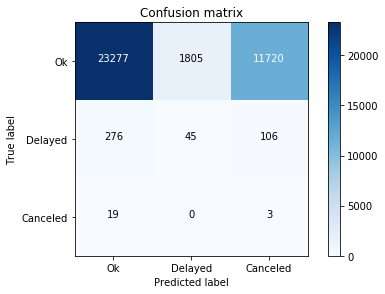

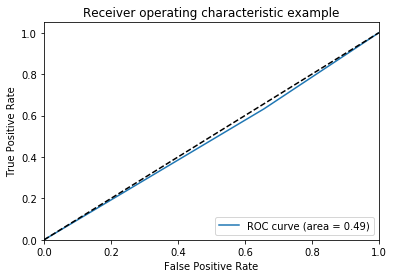

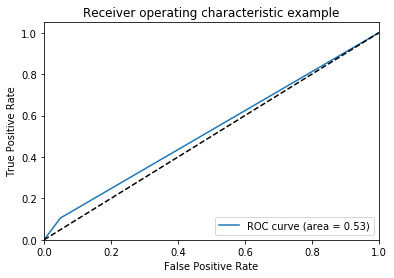

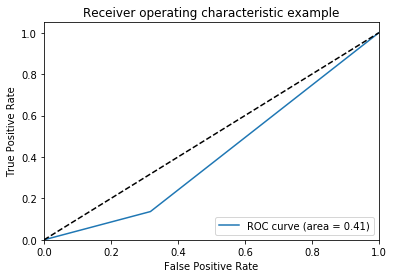

AUC Score:  0.48815593662886625
FbetaScore:  0.8774535788140962
Accuracy:  0.6261576870419586
------------------------------------------------
Samples of canceled flights
(109, 1)
Actual data shape: 
(327, 16) (327, 1)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')
Training time:  1.7367
------- Classificador 2: -------


247984    1
70887     1
123115    1
38410     1
5495      1
72375     1
128415    1
Name: Codigo.Justificativa, dtype: int64

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1


Confusion matrix: 
Confusion matrix, without normalization
[[36784     0    18]
 [  427     0     0]
 [   22     0     0]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


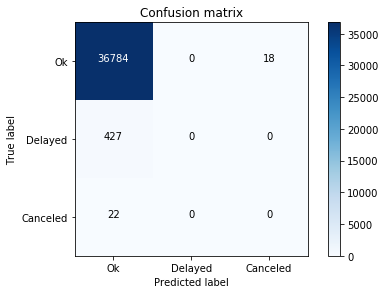

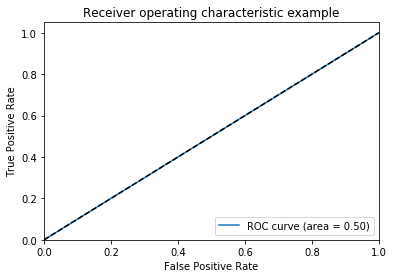

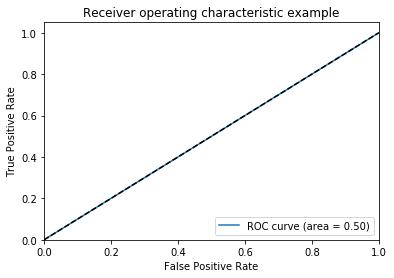

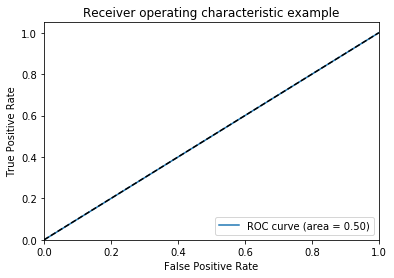

AUC Score:  0.4997582529748315
FbetaScore:  0.9782976978558983
Accuracy:  0.9874634238007033
------------------------------------------------
Samples of canceled flights
(109, 1)
Actual data shape: 
(327, 16) (327, 1)


/home/pgdock/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=500, random_state=200)
Training time:  50.6547
------- Classificador 3: -------


247984    1
70887     1
123115    1
38410     1
5495      1
72375     1
128415    1
Name: Codigo.Justificativa, dtype: int64

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1


Confusion matrix: 
Confusion matrix, without normalization
[[36477   324     1]
 [  415    12     0]
 [   22     0     0]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


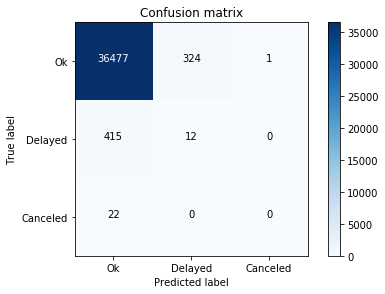

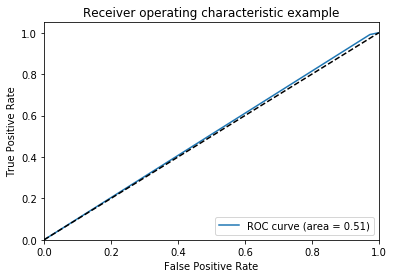

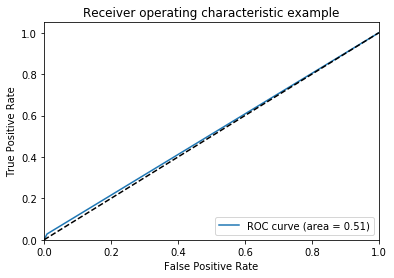

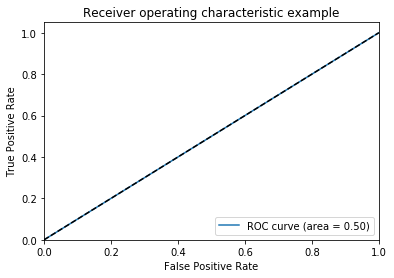

AUC Score:  0.5089502937617255
FbetaScore:  0.9772321107511398
Accuracy:  0.9795441733107836
------------------------------------------------


In [34]:
for i in range(1,4):
    choice = i
    if (choice == 1):
        start = time()
        clf = RandomForestClassifier()
        parameters = {"random_state": [200],  "n_estimators": [100,300,500]}
        X_aux, y_aux = pd.DataFrame(X_undersampled), pd.DataFrame(y_undersampled)
    elif(choice ==2):
        start = time()
        clf = KNeighborsClassifier()
        parameters = {'n_neighbors':list(range(1,30))}       
        
        X_aux, y_aux = pd.DataFrame(X_undersampled), pd.DataFrame(y_undersampled)
    elif(choice ==3):
        start = time()
        clf = AdaBoostClassifier()
        parameters = {"random_state": [200], "base_estimator": [DecisionTreeClassifier(max_depth=4)], "n_estimators": [100,300,500], "learning_rate":[0.5,1,2] }
        
        X_aux, y_aux = pd.DataFrame(X_undersampled), pd.DataFrame(y_undersampled)
    #elif (choice == 4):
    #    start = time()
    #    clf = RandomForestClassifier()
    #    parameters = {"random_state": [200],  "n_estimators": [100,300,500]}
    #    X_aux, y_aux = pd.DataFrame(X_oversampled), pd.DataFrame(y_oversampled)
    estimator = (clf)
    
    print ("Samples of canceled flights")
    print ((y_aux[y_aux.iloc[:, 0]==2]).shape)
    print("Actual data shape: ")
    print (X_aux.shape, y_aux.shape)
          
    grid_obj = GridSearchCV(estimator, parameters,cv=10,scoring=scorer, return_train_score =True)
    grid_fit = grid_obj.fit(X_aux, y_aux.values.ravel())
    

    end = time()
    trainTime = end - start
    best_clf = grid_fit.best_estimator_
    print(best_clf)
    print ("Training time:  {:.4f}".format(trainTime))
    
    best_predictions = pd.DataFrame(best_clf.predict(X_test))
    #y_score =  pd.DataFrame(best_clf.predict_proba(X_test))
    #print (y_score)
    

    print ("------- Classificador %d: -------" %i)
    #print ("Testing time:  {:.4f}".format(myMulti.testTime))
    display(y_test.head(7))
    display(best_predictions.head(7))
    print ("Confusion matrix: ")
    cm = confusion_matrix(y_test, best_predictions.iloc[:,0])
    plt.figure()
    plot_confusion_matrix(cm, classes=["Ok", "Delayed", "Canceled"],
                      title='Confusion matrix')
    
    print ("AUC Score: ", multiclass_roc_auc_score(y_test, best_predictions.iloc[:,0]))
    
    ##
    print("FbetaScore: ", fbeta_score(y_test,best_predictions.iloc[:,0],beta=0.5, average="weighted")) 
    print("Accuracy: ", accuracy_score(y_test,best_predictions.iloc[:,0]))
    print ("------------------------------------------------")
    #classificationReport

### Data Visualization

In [35]:
Data.columns =['Cod','tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4']




/home/pgdock/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pgdock/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pgdock/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pgdock/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pgdock/anaconda3/lib/python3.6

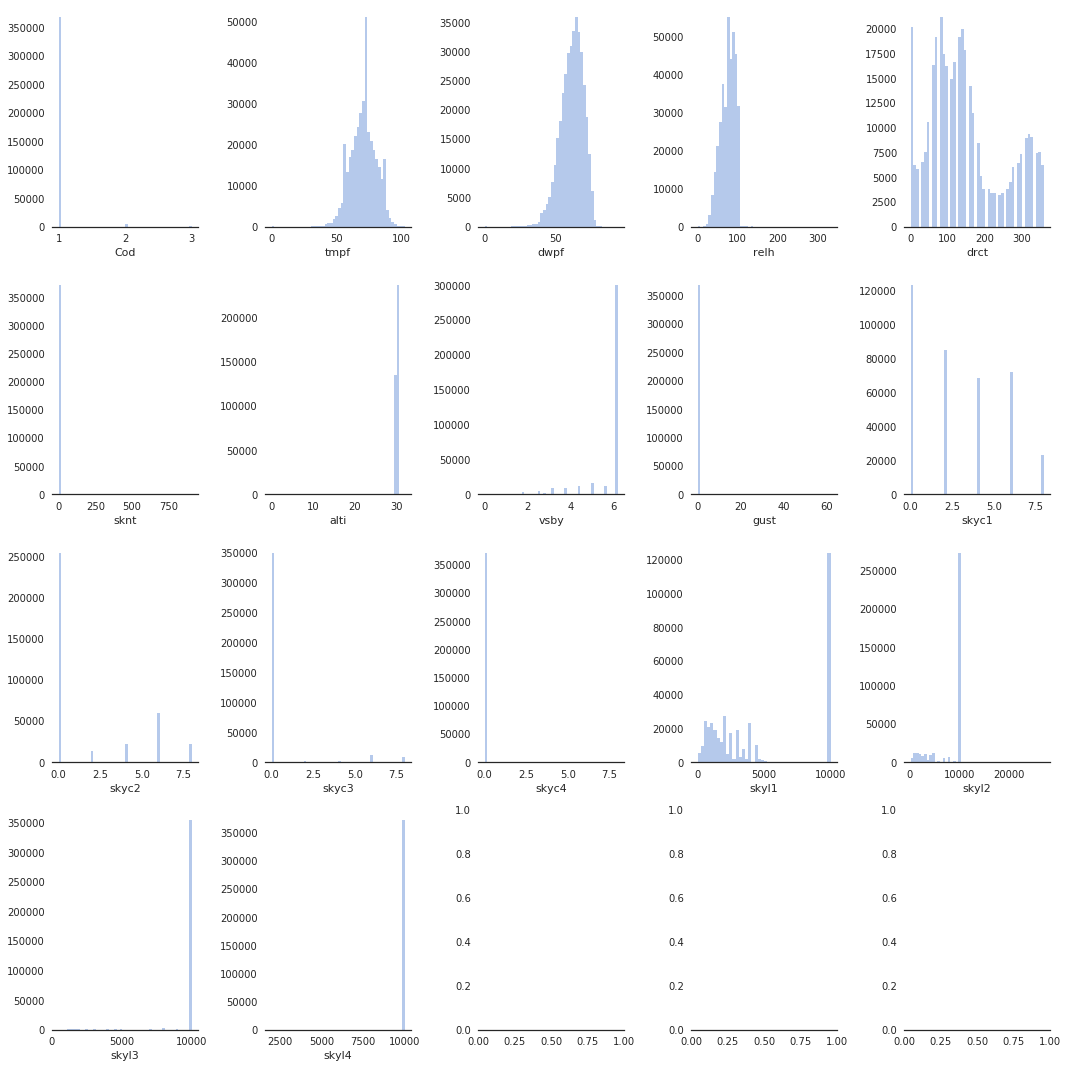

In [36]:
#data_mat['AvgGrade'] = data_mat[['G1', 'G2', 'G3']].mean(axis=1)
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(4, 5, figsize=(15,15))
sns.despine(left=True)

aux_0, aux_1 = 0,0

for i in Data:
    Data[i] = pd.to_numeric(Data[i])
    sns.distplot(Data[i],  kde=False, color="b", ax=axes[aux_0, aux_1])
    if (aux_1 <4):
        aux_1 += 1
    elif (aux_1 ==4):
        aux_0 += 1
        aux_1 = 0
    plt.tight_layout()

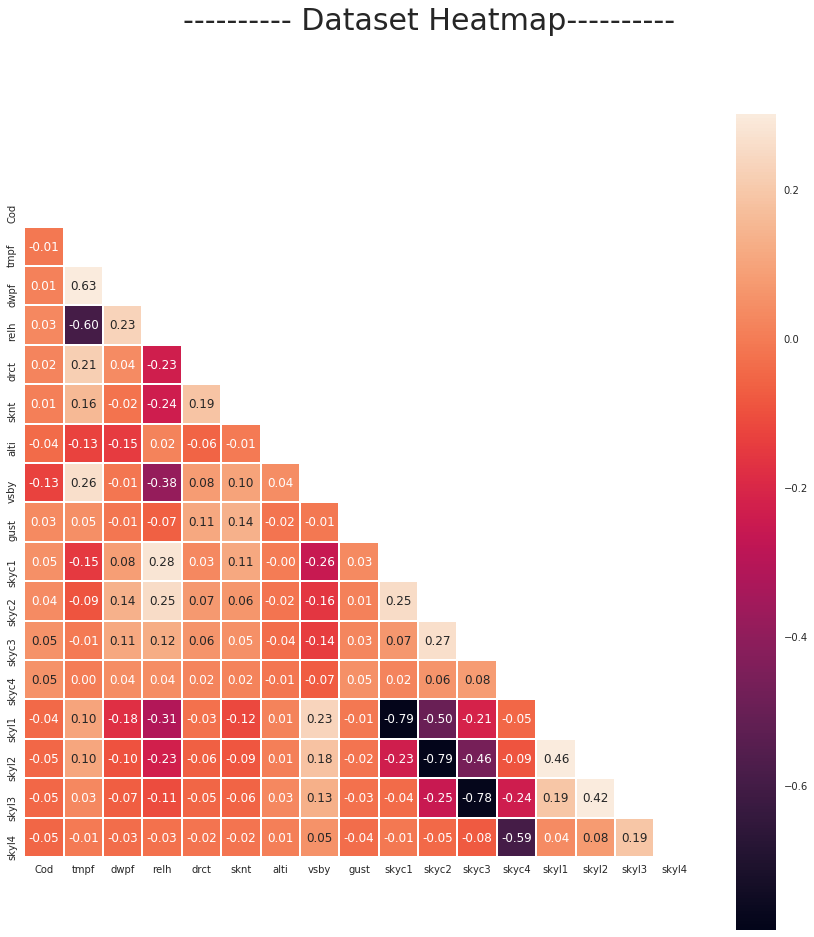

In [37]:
heatmap(Data,"---------- Dataset Heatmap----------")
print()

### Data Stats

In [38]:
Data.describe()

,Cod,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4
count,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000,372506.000000
mean,1.012185,70.501628,61.391377,75.340758,149.055613,5.959327,30.056958,5.773092,0.242375,2.850096,1.747113,0.389121,0.019098,4673.708880,8250.615829,9723.085534,9993.487890
std,0.112871,9.702776,7.761701,17.462032,100.435027,4.702275,0.499527,1.070225,2.436045,2.580383,2.758499,1.560551,0.356702,3902.661945,3139.067538,1331.873481,159.985192
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,500.000000,2000.000000
25%,1.000000,64.400000,57.200000,63.380000,80.000000,3.000000,29.970000,6.210000,0.000000,0.000000,0.000000,0.000000,0.000000,1300.000000,8000.000000,10000.000000,10000.000000
50%,1.000000,69.800000,62.600000,78.190000,130.000000,5.000000,30.060000,6.210000,0.000000,2.000000,0.000000,0.000000,0.000000,3000.000000,10000.000000,10000.000000,10000.000000
75%,1.000000,77.000000,66.200000,88.340000,210.000000,8.000000,30.150000,6.210000,0.000000,6.000000,4.000000,0.000000,0.000000,10000.000000,10000.000000,10000.000000,10000.000000
max,3.000000,102.200000,93.200000,331.090000,360.000000,905.000000,31.920000,6.210000,62.000000,8.000000,8.000000,8.000000,8.000000,10000.000000,27000.000000,10000.000000,10000.000000


# 